# Importing required libraries

## wandb dashboard link 
### https://wandb.ai/som/NBME?workspace=user-som
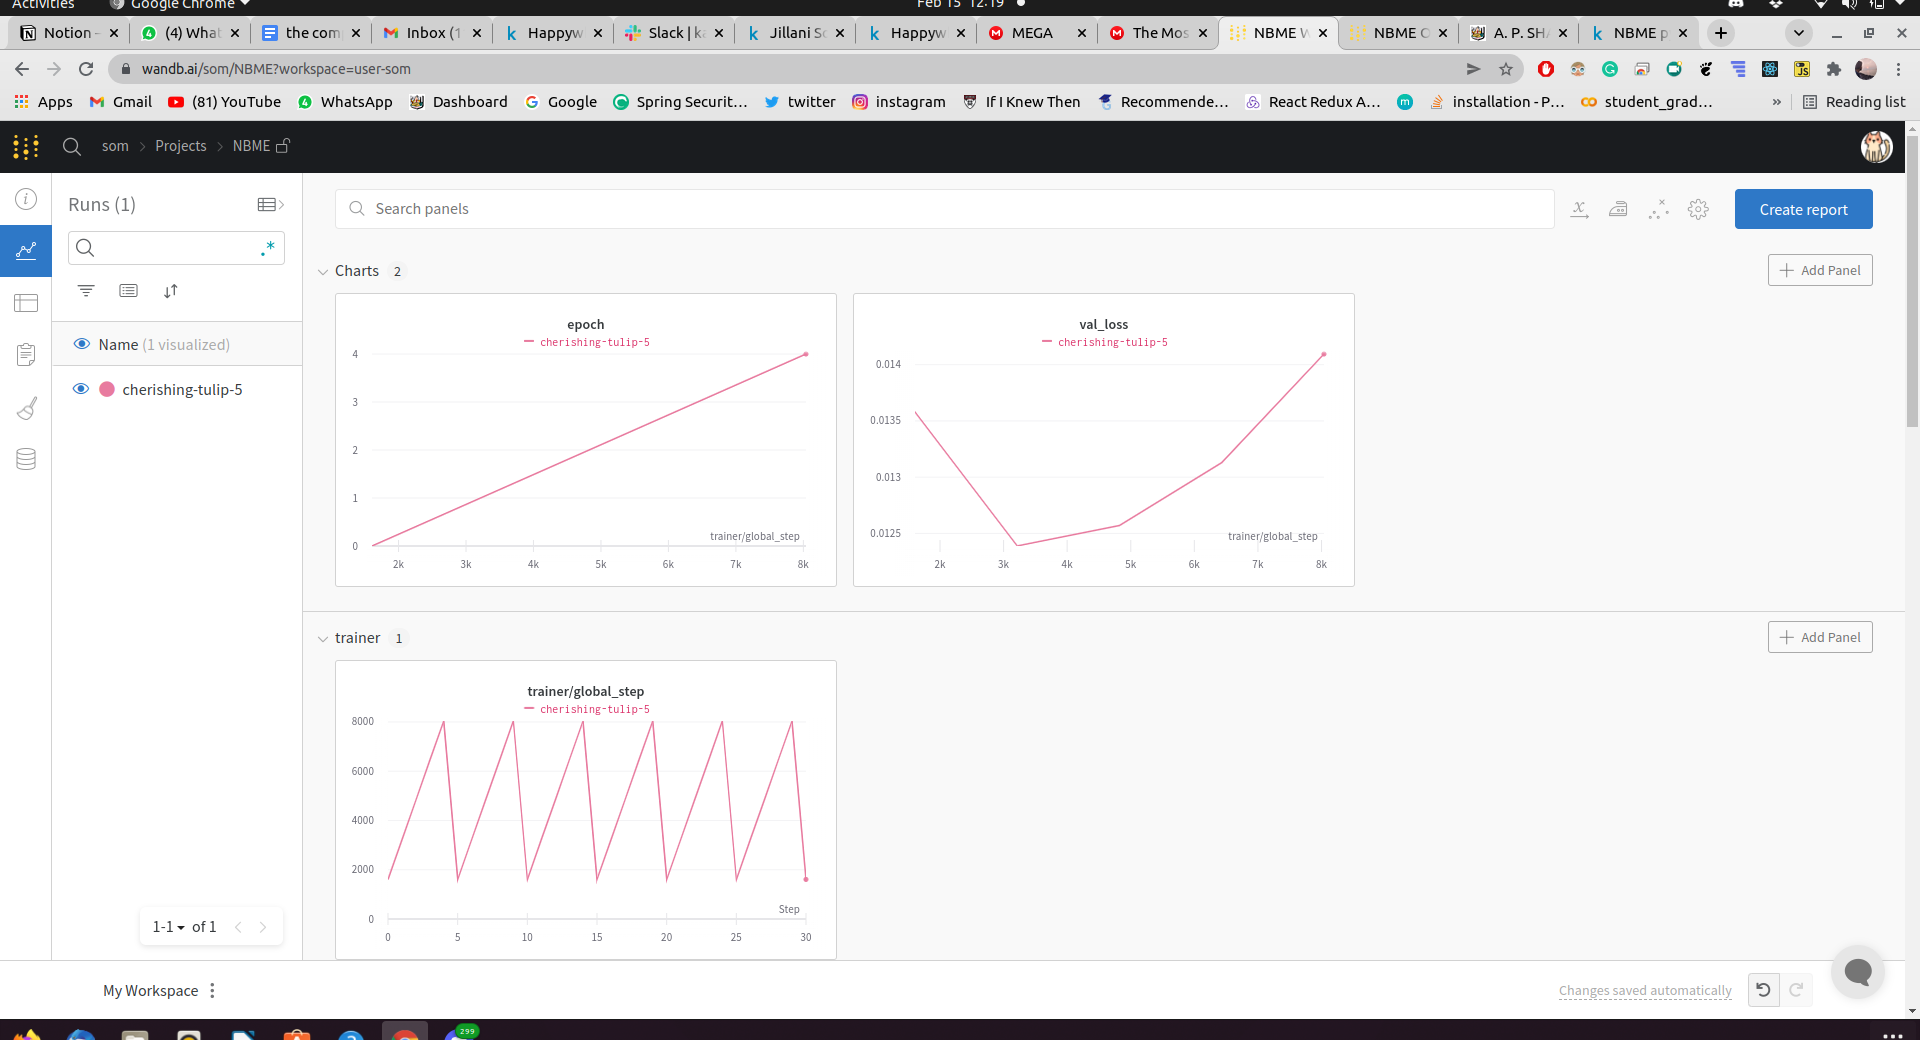

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import pytorch_lightning as pl 
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader , Dataset 
import wandb
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from transformers import (
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    PreTrainedTokenizerFast
)

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")

wandb.login(key = secret_value_0)

# helper functions 

In [ ]:
# From https://www.kaggle.com/theoviel/evaluation-metric-folds-baseline

def micro_f1(preds, truths):
    """
    Micro f1 on binary arrays.

    Args:
        preds (list of lists of ints): Predictions.
        truths (list of lists of ints): Ground truths.

    Returns:
        float: f1 score.
    """
    # Micro : aggregating over all instances
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    return f1_score(truths, preds)


def spans_to_binary(spans, length=None):
    """
    Converts spans to a binary array indicating whether each character is in the span.

    Args:
        spans (list of lists of two ints): Spans.

    Returns:
        np array [length]: Binarized spans.
    """
    length = np.max(spans) if length is None else length
    binary = np.zeros(length)
    for start, end in spans:
        binary[start:end] = 1
    return binary


def span_micro_f1(preds, truths):
    """
    Micro f1 on spans.

    Args:
        preds (list of lists of two ints): Prediction spans.
        truths (list of lists of two ints): Ground truth spans.

    Returns:
        float: f1 score.
    """
    bin_preds = []
    bin_truths = []
    for pred, truth in zip(preds, truths):
        if not len(pred) and not len(truth):
            continue
        length = max(np.max(pred) if len(pred) else 0, np.max(truth) if len(truth) else 0)
        bin_preds.append(spans_to_binary(pred, length))
        bin_truths.append(spans_to_binary(truth, length))
    return micro_f1(bin_preds, bin_truths)

def create_labels_for_scoring(df):
    # example: ['0 1', '3 4'] -> ['0 1; 3 4']
    df['location_for_create_labels'] = [ast.literal_eval(f'[]')] * len(df)
    for i in range(len(df)):
        lst = df.loc[i, 'location']
        if lst:
            new_lst = ';'.join(lst)
            df.loc[i, 'location_for_create_labels'] = ast.literal_eval(f'[["{new_lst}"]]')
    # create labels
    truths = []
    for location_list in df['location_for_create_labels'].values:
        truth = []
        if len(location_list) > 0:
            location = location_list[0]
            for loc in [s.split() for s in location.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                truth.append([start, end])
        truths.append(truth)
    return truths


def get_char_probs(texts, predictions, tokenizer):
    results = [np.zeros(len(t)) for t in texts]
    for i, (text, prediction) in enumerate(zip(texts, predictions)):
        encoded = tokenizer(text, 
                            add_special_tokens=True,
                            return_offsets_mapping=True)
        for idx, (offset_mapping, pred) in enumerate(zip(encoded['offset_mapping'], prediction)):
            start = offset_mapping[0]
            end = offset_mapping[1]
            results[i][start:end] = pred
    return results


def get_results(char_probs, th=0.5):
    results = []
    for char_prob in char_probs:
        result = np.where(char_prob >= th)[0] + 1
        result = [list(g) for _, g in itertools.groupby(result, key=lambda n, c=itertools.count(): n - next(c))]
        result = [f"{min(r)} {max(r)}" for r in result]
        result = ";".join(result)
        results.append(result)
    return results


def get_predictions(results):
    predictions = []
    for result in results:
        prediction = []
        if result != "":
            for loc in [s.split() for s in result.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                prediction.append([start, end])
        predictions.append(prediction)
    return predictions

In [ ]:
class CFG:
    max_len=360
    
CFG.num_folds = 3
CFG.name = "dmis-lab/bern2-ner"# "microsoft/deberta-large" #"microsoft/deberta-base" #"emilyalsentzer/Bio_ClinicalBERT"
# CFG.token_name = "../input/deberta-v2-3-fast-tokenizer"
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.name)
CFG.batch_size = 2 #10 #8
CFG.num_workers = 0
CFG.num_epochs = 2 #8 #10 

In [ ]:
# torch.cuda.empty_cache()
# !nvidia-smi

In [ ]:
CFG.tokenizer.save_pretrained("./deberta_large_tokenizer")

# Data Loading 
from notebook https://www.kaggle.com/yasufuminakama/nbme-deberta-base-baseline-train#Utils

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('../input/nbme-score-clinical-patient-notes/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval)
train['location'] = train['location'].apply(ast.literal_eval)
features = pd.read_csv('../input/nbme-score-clinical-patient-notes/features.csv')
def preprocess_features(features):
    features.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago"
    return features
features = preprocess_features(features)
patient_notes = pd.read_csv('../input/nbme-score-clinical-patient-notes/patient_notes.csv')

print(f"train.shape: {train.shape}")
display(train.head())
print(f"features.shape: {features.shape}")
display(features.head())
print(f"patient_notes.shape: {patient_notes.shape}")
display(patient_notes.head())
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
display(train.head())
# incorrect annotation
train.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')

train['annotation_length'] = train['annotation'].apply(len)
display(train['annotation_length'].value_counts())

Fold = GroupKFold(n_splits=CFG.num_folds)
groups = train['pn_num'].values
for n, (train_index, val_index) in enumerate(Fold.split(train, train['location'], groups)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

# building dataset 



In [ ]:
def prepare_input(cfg, text, feature_text):
    inputs = cfg.tokenizer(text, feature_text, 
                           add_special_tokens=True,
                           max_length=CFG.max_len,
                           padding="max_length",
                           truncation=True,
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


def create_label(cfg, text, annotation_length, location_list):
    encoded = cfg.tokenizer(text,
                            add_special_tokens=True,
                            max_length=CFG.max_len,
                            padding="max_length",
                            truncation=True,
                            return_offsets_mapping=True)
    offset_mapping = encoded['offset_mapping']
    ignore_idxes = np.where(np.array(encoded.sequence_ids()) != 0)[0]
    label = np.zeros(len(offset_mapping))
    label[ignore_idxes] = -1
    if annotation_length != 0:
        for location in location_list:
            for loc in [s.split() for s in location.split(';')]:
                start_idx = -1
                end_idx = -1
                start, end = int(loc[0]), int(loc[1])
                for idx in range(len(offset_mapping)):
                    if (start_idx == -1) & (start < offset_mapping[idx][0]):
                        start_idx = idx - 1
                    if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                        end_idx = idx + 1
                if start_idx == -1:
                    start_idx = end_idx
                if (start_idx != -1) & (end_idx != -1):
                    label[start_idx:end_idx] = 1
    return torch.tensor(label, dtype=torch.float)


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.feature_texts = df['feature_text'].values
        self.pn_historys = df['pn_history'].values
        self.annotation_lengths = df['annotation_length'].values
        self.locations = df['location'].values

    def __len__(self):
        return len(self.feature_texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, 
                               self.pn_historys[item], 
                               self.feature_texts[item])
        label = create_label(self.cfg, 
                             self.pn_historys[item], 
                             self.annotation_lengths[item], 
                             self.locations[item])
        return inputs, label

In [ ]:
# save baseline model 
base_mod = AutoModel.from_pretrained(CFG.name)

In [ ]:
base_mod.save_pretrained(CFG.name)
del base_mod

In [ ]:
class BaseLineModel(pl.LightningModule):
    def __init__(self,mod_name="dmis-lab/bern2-ner",#microsoft/deberta-base
                 learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,):
        super().__init__()
        self.save_hyperparameters()
        self.config = AutoConfig.from_pretrained(mod_name, output_hidden_states=True)
        self.base = AutoModel.from_pretrained(mod_name,config=self.config)
#         self.lin1 = nn.Linear(self.config.hidden_size, 256)
#         self.lin2 = nn.Linear(256, 1)
        self.fc_dropout_0 = nn.Dropout(0.1)
        self.fc_dropout_1 = nn.Dropout(0.2)
        self.fc_dropout_2 = nn.Dropout(0.3)
        self.fc_dropout_3 = nn.Dropout(0.4)
        self.fc_dropout_4 = nn.Dropout(0.5)
        self.fc = nn.Linear(self.config.hidden_size, 1)
    
    def forward(self, inputs):
        base_outs = self.base(**inputs)
        output_0 = self.fc(self.fc_dropout_0(base_outs[0]))
        output_1 = self.fc(self.fc_dropout_1(base_outs[0]))
        output_2 = self.fc(self.fc_dropout_2(base_outs[0]))
        output_3 = self.fc(self.fc_dropout_3(base_outs[0]))
        output_4 = self.fc(self.fc_dropout_4(base_outs[0]))
        output = (output_0 + output_1 + output_2 + output_3 + output_4) / 5
        return output

    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        y_preds = self(inputs)
        loss = nn.BCEWithLogitsLoss(reduction="none")(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()

        return {"loss":loss}
    
    def validation_step(self, batch ,batch_idx):
        inputs, labels = batch
        preds = self(inputs)
        val_loss = nn.BCEWithLogitsLoss(reduction="none")(preds.view(-1, 1), labels.view(-1, 1))
        val_loss = torch.masked_select(val_loss, labels.view(-1, 1) != -1).mean()
        self.log("val_loss", val_loss)
        return {"loss": val_loss, "preds": preds, "labels": labels}

    
    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        model = self
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)

        return [optimizer]
        


        

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# instrument experiment with W&B
wandb_logger = WandbLogger(project="NBME", log_model= True)

for fold in range(CFG.num_folds):
    train_folds = train[train['fold']!=fold]
    val_folds = train[train['fold']== fold]
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, val_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


    model = BaseLineModel(mod_name = CFG.name)
    trainer = pl.Trainer(logger=wandb_logger,max_epochs=CFG.num_epochs,gpus=1, precision=16)#, callbacks=[EarlyStopping(monitor="val_loss")]
    trainer.fit(model, train_dataloader=train_loader, val_dataloaders=valid_loader)
    trainer.save_checkpoint(f"model_fold{fold}.ckpt")


# things to try out 

In [ ]:
    
#     def validation_epoch_end(self, outputs):
#         preds = torch.cat([x["preds"] for x in outputs]).detach().cpu().numpy()
#         labels = torch.cat([x["labels"] for x in outputs]).detach().cpu().numpy()
#         loss = torch.stack([x["loss"] for x in outputs]).mean()
#         char_probs = get_char_probs(valid_texts, predictions, CFG.tokenizer)
#         results = get_results(char_probs, th=0.5)
#         preds = get_predictions(results)
#         score = get_score(valid_labels, preds)
        
#         self.log_dict(span_micro_f1(labels, preds), prog_bar=True)
#         return loss